The cell below sets up an optimization!

  Gradient will be taken with respect to all layers! 


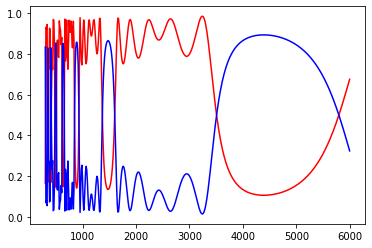

 Filter FOM 217.04445526587529
length is  5
grad is  [-4414713.03178024 -3180728.1981831  -6099294.3628404  -2440797.37509464
 -2459784.18178634]


In [3]:
from wptherml.wpml import multilayer
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import basinhopping
import time
from numpy import linalg as LA
import numpy as np

d1 = 4500e-9/(4*2.37)
d2 = 4500e-9/(4*1.5)
### This will define the base filter that will be optimized
structure = {
        'Material_List' : ['Air','Ta2O5', 'SiO2', 'Ta2O5', 'SiO2', 'PS', 'SiO2'],
        ### Thicknesses just chosen arbitrarily, replace with "optimal" values
        'Thickness_List': [0, d1, d2, d1, d2, d1, 0 ],
        'Lambda_List': [300e-9, 6000e-9, 500],
        'Temperature': 300

       }

#structure = {
#        'Material_List' : ['Air', 'Ta2O5','SiO2','Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5','SiO2', 'Ta2O5', 'SiO2', 'Air'],
#        ### Thicknesses just chosen arbitrarily, replace with "optimal" values
#        'Thickness_List': [0, 18e-9, 47e-9, 156e-9, 212e-9, 178e-9, 23e-9, 51e-9, 224e-9, 150e-9, 205e-9, 258e-9, 187e-9, 243e-9, 190e-9, 266e-9, 215e-9, 153e-9, 227e-9, 154e-9, 226e-9, 152e-9, 245e-9, 24e-9, 229e-9, 263e-9, 190e-9, 257e-9, 200e-9, 260e-9, 224e-9, 27e-9,  229e-9, 154e-9, 219e-9, 274e-9, 198e-9, 405e-9, 211e-9, 166e-9, 233e-9, 47e-9, 66e-9, 17e-9, 125e-9, 153e-9, 237e-9, 151e-9, 225e-9, 147e-9, 193e-9, 127e-9, 214e-9, 135e-9, 173e-9, 112e-9, 165e-9, 130e-9, 223e-9, 130e-9, 163e-9, 112e-9, 164e-9, 114e-9, 167e-9, 121e-9, 378e-9, 114e-9, 160e-9, 113e-9, 174e-9, 117e-9, 211e-9, 23e-9, 221e-9, 261e-9, 399e-9, 266e-9, 390e-9, 28e-9, 18e-9, 367e-9, 198e-9, 302e-9, 28e-9, 33e-9, 426e-9, 31e-9, 15e-9, 222e-9, 96e-9, 0 ],
#        'Lambda_List': [400e-9, 3500e-9, 400],
#        'Temperature': 300,
#
#        }

### create instance called cc
cc = multilayer(structure)
cc.layer_static_ri(1,2.37)
cc.layer_static_ri(3,2.37)
cc.layer_static_ri(5,2.37)
cc.fresnel()
plt.plot(cc.lambda_array*1e9, cc.transmissivity_array, 'red')
plt.plot(cc.lambda_array*1e9, cc.reflectivity_array, 'blue')
plt.show()

### get initial luminous efficiency of W-emitter / filter pair
cc.filter_fom()
cc.fresnel_prime()

print(" Filter FOM", cc.filter_fom_val*100)
cc.filter_grad()
### How many elements in the filter will be varied over?
length = len(cc.filter_fom_grad)
print("length is ",length)
print("grad is ",cc.filter_fom_grad)

### given an array of thicknesses for a stack stored in x0, re-compute figure of merit
def update_multilayer(x0):
    dim = len(x0)
    for i in range(1,dim+1):
        cc.d[i] = x0[i-1]*1e-9
        
    cc.fresnel()
    cc.filter_fom()
    return -cc.filter_fom_val*100

### given an array of thicknesses x0, compute the gradient of fom wrt stack geometry
def analytic_grad(x0):
    dim = len(x0)
    g = np.zeros(dim)
    cur = update_multilayer(x0)
    cc.fresnel_prime()
    cc.filter_grad()
    g = cc.filter_fom_grad
    return -g*1e-7

### Function that gets the negative of the efficiency and the 
### negative of the gradient for use in the l-bfgs-b algorithm
### also prints out the time for timing purposes!
def SuperFunc(x0):
    en = update_multilayer(x0)
    c_time = time.time()
    gr = analytic_grad(x0)
    return en, gr




In [1]:
'''RUN THIS CELL IF YOU WANT TO OPTIMIZE!'''
# the bounds for L-BFGS-B updates!
bfgs_xmin = np.ones(length)
bfgs_xmax = 2000*np.ones(length)

# rewrite the bounds in the way required by L-BFGS-B
bfgs_bounds = [(low, high) for low, high in zip(bfgs_xmin, bfgs_xmax)]

### initialize the solution vector xs to be the thicknesses from 
### the structure dictionary
xs = np.zeros(length)
for i in range(0,length):
    xs[i] = cc.d[i+1]*1e9

### print out initial solution vector and initial efficiency
print("xs is ")
print(xs)
print("efficiency is ",update_multilayer(xs))

#### run l-bfgs-b algorithm!
ret = minimize(SuperFunc, xs, method="L-BFGS-B", jac=True, bounds=bfgs_bounds)

### print optimal solution and its efficiency!
print(ret.x)
print(update_multilayer(ret.x))
                                  

NameError: name 'np' is not defined

### These two cells setup and compute integrals over the various spectra

  Gradient will be taken with respect to all layers! 


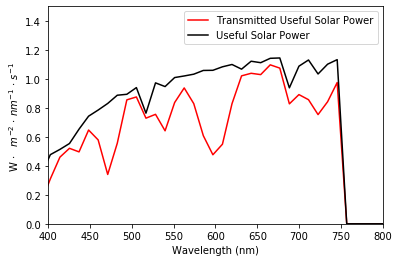

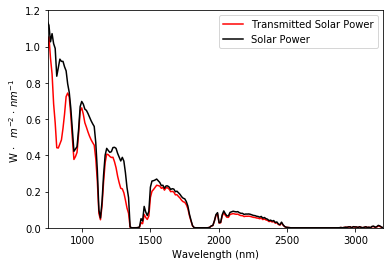

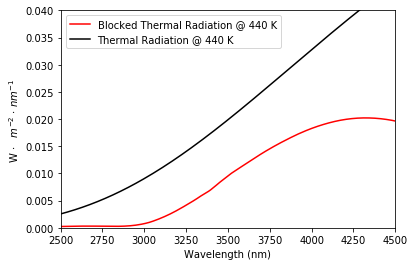

In [4]:
import numpy as np
from wptherml.datalib import datalib
from wptherml.numlib import numlib

step = np.zeros(len(cc.lambda_array))
for i in range(0,len(cc.lambda_array)):
    if cc.lambda_array[i]<750e-9:
        step[i] = 1
        
cc = multilayer(structure)
AM = datalib.AM(cc.lambda_array)
BBs = datalib.BB(cc.lambda_array, 440)
lbg = 750e-9
curve_1 = cc.transmissivity_array * AM * cc.lambda_array / lbg * step
curve_2 = AM * cc.lambda_array/lbg * step

curve_3 = cc.transmissivity_array * AM

curve_5 = cc.reflectivity_array * BBs

plt.plot(cc.lambda_array*1e9, curve_1*1e-9, 'red', label='Transmitted Useful Solar Power')
plt.plot(cc.lambda_array*1e9, curve_2*1e-9, 'black', label='Useful Solar Power')
plt.ylabel("W $\cdot$   $m^{-2}$ $\cdot$ $nm^{-1}$ $\cdot$ $s^{-1}$ ")
plt.xlabel("Wavelength (nm)")
plt.xlim(400,800)
plt.ylim(0,1.5)
plt.legend()
#plt.savefig("Fig1_SiO2_Sub.png")
plt.show()

plt.plot(cc.lambda_array*1e9, curve_3*1e-9, 'red', label='Transmitted Solar Power')
plt.plot(cc.lambda_array*1e9, AM*1e-9, 'black', label='Solar Power')
plt.ylabel("W $\cdot$   $m^{-2}$ $\cdot$ $nm^{-1}$ ")
plt.xlabel("Wavelength (nm)")
plt.xlim(750,3200)
plt.ylim(0,1.2)
plt.legend()
#plt.savefig("Fig2_SiO2_Sub.png")
plt.show()

plt.plot(cc.lambda_array*1e9, curve_5*1e-9, 'red', label='Blocked Thermal Radiation @ 440 K')
plt.plot(cc.lambda_array*1e9, BBs*1e-9, 'black', label='Thermal Radiation @ 440 K')
plt.ylabel("W $\cdot$   $m^{-2}$ $\cdot$ $nm^{-1}$ ")
plt.xlabel("Wavelength (nm)")
plt.xlim(2500,4500)
plt.ylim(0,0.04)
plt.legend()
#plt.savefig("Fig3_SiO2_Sub.png")
plt.show()


In [5]:
curve_a = cc.transmissivity_array * BBs
curve_b = BBs 
#curve_c = AM

som_a = numlib.Integrate(curve_a, cc.lambda_array, 0, 3200e-9)
som_b = numlib.Integrate(curve_b, cc.lambda_array, 0, 3200e-9)

print(som_b, som_a, som_a/som_b)

5.446518241680279 4.604975395155796 0.845489758928107
